In [10]:
import torch
import time  
import numpy as np 
from torch import nn, Tensor, optim
from torch.nn.parameter import Parameter 
from torch.optim.optimizer import Optimizer, required

from typing import List, Optional, Callable, Tuple

import libs.hij_tensor as pt
import libs.py_fock as fock
import libs.py_integral as integral

from vmc.PublicFunction import check_para, unit8_to_bit, setup_seed
from vmc.ansatz import rRBMWavefunction
from vmc.optim import SR
from vmc.eloc import local_energy, total_energy
from vmc.sample import MCMCSampler

In [11]:
import os
os.system("pwd") 
os.environ["CUDA_LAUNCH_BLOCKING"]= '1'

/home/zbwu/university/research/notes/cpp-python/torch_Full_CI/experimental


In [12]:
def string_to_lst(sorb: int, string: str):
    arr = np.array(list(map(int, string)))[::-1]
    lst = [0] * ((sorb-1)//64 +1)*8
    for i in range((sorb-1)//8+1):
        begin = i * 8
        end = (i+1) * 8 if (i+1)*8 < sorb else sorb
        idx = arr[begin:end]
        lst[i] = np.sum(2**np.arange(len(idx)) * idx)

    return lst

chain_len = 2
integral_file = f"../integral/rmole-H2-0.734.info"
int2e, int1e, ecore = integral.load(integral.two_body(), integral.one_body(), 0.0, integral_file)
print(ecore)
sorb = int2e.sorb
nele = 2
alpha_ele = nele//2 
beta_ele = nele//2
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
space = fock.get_fci_space(int(sorb//2), alpha_ele, beta_ele)
dim = len(space)

# h1e/h2e 
h1e = torch.tensor(int1e.data, dtype=torch.float64).to(device)
h2e = torch.tensor(int2e.data, dtype=torch.float64).to(device)

# bra/ket
lst = []
for i in range(dim):
    lst.append(string_to_lst(sorb, space[i].to_string()))
onstate1 = torch.tensor(lst, dtype=torch.uint8).to(device)
# onstate2 = torch.tensor(lst, dtype=torch.uint8).to(device)
print(onstate1)


integral::load fname = ../integral/rmole-H2-0.734.info
0.7209498786376022
sorb = 4
size(int1e) = 16:0.000122MB:1.19e-07GB
size(int2e) = 27:0.000206MB:2.01e-07GB
----- TIMING FOR integral::load_integral : 0.000e+00 S -----
tensor([[ 3,  0,  0,  0,  0,  0,  0,  0],
        [ 9,  0,  0,  0,  0,  0,  0,  0],
        [ 6,  0,  0,  0,  0,  0,  0,  0],
        [12,  0,  0,  0,  0,  0,  0,  0]], dtype=torch.uint8)


In [45]:
def compute_derivs(derivs, Eloc, N_s, p):
    """Computes variational derivatives and update to params"""
    
    # print(sigmas)
    # theta = np.dot(weights.transpose(),
    #                sigmas.transpose()) + B  # n_h x N_s
    # dA = sigmas.transpose()  # n_spins x N_s
    # dB = np.tanh(theta)  # n_h x N_s
    # dW = sigmas.transpose().reshape((n_spins, 1, N_s)) * \
    #      np.tanh(theta.reshape((1, n_h, N_s)))
    # derivs = np.concatenate([dA, dB, dW.reshape(n_spins * n_h, N_s)])
   
    print(f"derivs shape {derivs.shape}")
    # print(f"N_s {N_s}")

    avg_derivs = np.sum(derivs, axis=1, keepdims=True) / N_s
    avg_derivs_mat = np.conjugate(avg_derivs.reshape(derivs.shape[0], 1))
    # print(np.allclose(
    #     avg_derivs_mat.real,
    #     avg_derivs.real
    # ))

    # print(avg_derivs_mat.shape)
    avg_derivs_mat = avg_derivs_mat * avg_derivs.reshape(
        1, derivs.shape[0]
    )
    # print(derivs.shape, avg_derivs.shape, avg_derivs_mat.shape)
    moment2 = np.einsum('ik,jk->ij', np.conjugate(derivs), derivs) / N_s
    # print(f"moment2: {moment2}")
    S_kk = np.subtract(moment2, avg_derivs_mat)
    # print(f"moment2 shape {moment2.shape}")
    # print(Eloc.shape)
    F_p = np.sum(Eloc.transpose() * np.conjugate(derivs), axis=1) / N_s
    F_p -= np.sum(Eloc.transpose(), axis=1) * \
           np.sum(np.conjugate(derivs), axis=1) / (N_s ** 2)
    print(f"F_p shape {F_p.shape}")
    S_kk2 = np.zeros(S_kk.shape, dtype=complex)
    row, col = np.diag_indices(S_kk.shape[0])
    S_kk2[row, col] = 0.02 # np.diagonal(S_kk) * regular(p)
    S_reg = S_kk + S_kk2
    update = np.dot(np.linalg.inv(S_reg), F_p).reshape(derivs.shape[0], 1)
    
    # print(f"S_reg shape {S_reg.shape}")
    # print(f"S_kk shape {S_kk.shape}")
    # print(f"F_p shape {F_p.shape}")
    # print(f"S_reg-1: {np.linalg.inv(S_reg).shape}")
    # print(f"update shape {update.shape}")
    # print(f"ssss {np.dot(np.linalg.inv(S_reg), F_p).shape}") 
    return update

def regular(p, l0=100, b=0.9, l_min=1e-4):
    """
    Lambda regularization parameter for S_kk matrix,
    see supplementary materials
    """

    return max(l0 * (b**p) , l_min)

In [59]:
def sr(eloc: Tensor, grad_total: Tensor, N_state: int, p: int, 
      debug=False, L2_penalty: Tensor = None) -> Tensor:


    avg_grad = torch.sum(grad_total, axis=0, keepdim=True)/N_state
    avg_grad_mat = avg_grad.reshape(-1, 1)
    # avg_grad_mat = torch.conj(avg_grad.reshape(-1, 1))
    avg_grad_mat = avg_grad_mat * avg_grad.reshape(1, -1)
    # moment2 = torch.einsum("ki, kj->ij", torch.conj(grad_total), grad_total)/N_state
    moment2 = torch.einsum("ki, kj->ij", grad_total, grad_total)/N_state
    S_kk = torch.subtract(moment2, avg_grad_mat)
    
    F_p = torch.sum(eloc.transpose(1, 0) * grad_total, axis=0)/N_state
    F_p -= torch.sum(eloc.transpose(1, 0), axis=0) * torch.sum(grad_total, axis=0)/(N_state**2)
    if L2_penalty is not None:
        F_p += L2_penalty
    # F_p = torch.sum(eloc.transpose(1, 0) * torch.conj(grad_total), axis=0)/N_state
    # F_p -= torch.sum(eloc.transpose(1, 0), axis=0) * torch.sum(torch.conj(grad_total), axis=0)/(N_state**2)
    S_kk2 = torch.zeros_like(S_kk)
    row = torch.arange(S_kk.shape[0])
    S_kk2[row, row] = 0.02 # regular(p) * torch.diag(S_kk)
    S_reg = S_kk + S_kk2
    # if debug:
    #     print(f"S_kk.-1", torch.linalg.inv(S_reg))
    update = torch.matmul(torch.linalg.inv(S_reg), F_p).reshape(1, -1)
    return update

def calculate_sr_grad(params: List[Tensor], 
                      grad_save: List[Tensor], 
                      eloc: Tensor, 
                      N_state: int,
                      p: int, 
                      lr: float = 0.02):
    shape_lst = []
    grad_comb_lst = []
    n_para = len(grad_save[0])
    for i in range(n_para):
        shape_lst.append(grad_save[0][i].shape)
        comb = []
        for j in range(N_state):
            comb.append(grad_save[j][i].reshape(1, -1))
        grad_comb_lst.append(torch.cat(comb))
    
    param_group = list(params)
    for i in range(n_para):
        L2 = 0.001 * (param_group[i].detach().clone()**2).reshape(-1)
        update = sr(eloc, grad_comb_lst[i], N_state, p, debug = (i==1), L2_penalty=L2)
        # print(f"grad_comb {grad_comb_lst[i]}")
        update1 = compute_derivs(grad_comb_lst[i].T.cpu().detach().numpy(), eloc.T.cpu().detach().numpy(), N_state, p)
        print("sssss", np.allclose(
            update.detach().cpu().numpy(),
            update1.real.T
        ))
        if i == 1:
            print(f"update {update}")
        print(f"update1 {update1}")
        param_group[i].data.add_(update.reshape(shape_lst[i]), alpha=-lr)
        del update

In [60]:
print(onstate1)

tensor([[ 3,  0,  0,  0,  0,  0,  0,  0],
        [ 9,  0,  0,  0,  0,  0,  0,  0],
        [ 6,  0,  0,  0,  0,  0,  0,  0],
        [12,  0,  0,  0,  0,  0,  0,  0]], dtype=torch.uint8)


In [64]:
grad_lst = []
out_lst = []

def hook_fn_backward(model, grad_in, grad_out):
    lst = []
    for para in model.parameters():
        if para.grad is not None:
            lst.append(para.grad.detach().clone())
    grad_lst.append(lst)
    del lst 

def hook_fn_forward(model, data_in, data_out):
    out_lst.append(data_out.detach().clone())

# ecore = 0.00
# seed = 42
# setup_seed(seed)
e_list =[]
model = rRBMWavefunction(sorb, sorb, init_weight=0.002).to(device)
print(model)
x0 = onstate1[0].clone()
print(x0)
time_sample = []
time_iter = []


with torch.no_grad():
    nbatch  =  len(onstate1)
    e, exp_op = total_energy(onstate1, nbatch, h1e, h2e, 
                                 model,ecore, sorb, nele, device=device)
    e_list.append(e.item())
print(f"begin e is {e}")

from vmc.optim import SR

n = 60
debug = True
N = onstate1.shape[0] if debug else n
print(onstate1.shape)


opt = SR(model.parameters(), lr=0.005, N_state=N)

for p in range(1000):
    grad_lst = []
    out_lst = []
    t0 = time.time_ns()
    sample = MCMCSampler(model, x0.detach(), h1e, h2e , n, sorb, nele, 
                        verbose=True, debug_exact=debug, full_space=onstate1)
    state, eloc = sample.run() # eloc [n_sample]
    print("state: ")
    print(state)
    print("local energy")
    print(eloc)
    n_sample = len(state)
    # TODO: cuda version unit8_to_bit 2D
    sample_state = unit8_to_bit(state, sorb)
    delta = (time.time_ns() - t0)/1.00E09
    time_sample.append(delta)

    for i in range(n_sample):
        model.zero_grad()
        handle = model.register_full_backward_hook(hook_fn_backward)
        a = model(sample_state[i].requires_grad_(), sample=False)
        # weights = torch.ones(10, dtype=torch.double, device=device) * 0.10
        a.backward()
        # for para in model.parameters():
        #     print(f"grad: {para.grad}")
        handle.remove()
        del a 
    
    calculate_sr_grad(model.parameters(), grad_lst, eloc.reshape(1, -1), N, p+1, lr=0.005)
    # opt.step(grad_lst, eloc.reshape(1, -1), p+1)
    opt.zero_grad()

    with torch.no_grad():
        nbatch  = n_sample
        e, exp_op = total_energy(state.detach(), nbatch, h1e, h2e, 
                                 model, ecore, sorb, nele, device=device)
        e_list.append(e.item())
    print(f"{p} iteration total energy is {e:.5f}")
    time_iter.append((time.time_ns() - t0)/1.00E09)
    del grad_lst, out_lst

# x0 = torch.tensor([1.0, 1.0, -1.0, -1.0], dtype=torch.float, requires_grad=True).to(device)
# handle = net.register_full_backward_hook(hook_fn_backward)
# y = net(x0)
# y.backward()

rRBMWavefunction(RBMWavefunction: num_visible=4, num_hidden=4)
tensor([3, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
CPU Hmat initialization time: 0.003055 ms
CPU calculate <n|H|m> time: 0.002415 ms
Total CPU function time: 0.030074 ms

begin e is -0.331507805785486
torch.Size([4, 8])
CPU Hmat initialization time: 0.00234 ms
CPU calculate <n|H|m> time: 0.00248 ms
Total CPU function time: 0.023335 ms

comb_x time: 0.021 ms, unit8_to_bit time: 0.005 ms, nqs time: 0.350 ms
state: 
tensor([[ 3,  0,  0,  0,  0,  0,  0,  0],
        [ 9,  0,  0,  0,  0,  0,  0,  0],
        [ 6,  0,  0,  0,  0,  0,  0,  0],
        [12,  0,  0,  0,  0,  0,  0,  0]], dtype=torch.uint8)
local energy
tensor([-1.6573, -1.2446, -1.2441, -0.0627], dtype=torch.float64,
       grad_fn=<SumBackward1>)
grad_comb tensor([[ 1.,  1., -1., -1.],
        [ 1., -1., -1.,  1.],
        [-1.,  1.,  1., -1.],
        [-1., -1.,  1.,  1.]], dtype=torch.float64)
torch.Size([4, 4])
derivs shape (4, 4)
F_p shape (4,)
sssss True
grad

In [65]:
with torch.no_grad():
    nbatch  =  len(onstate1)
    e, exp_op = total_energy(onstate1, nbatch, h1e, h2e, 
                                 model,ecore, sorb, nele, device=device)
    e_list.append(e.item())
print(f"begin e is {e}")

CPU Hmat initialization time: 0.005249 ms
CPU calculate <n|H|m> time: 0.002774 ms
Total CPU function time: 0.034124 ms

begin e is nan


-1.1156705004758725


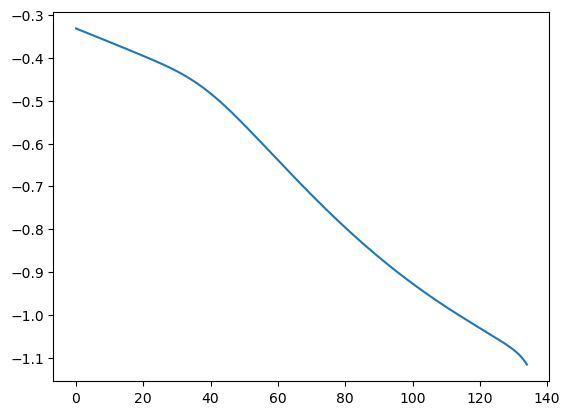

In [71]:
import numpy as np
import matplotlib.pyplot as plt
e = np.array(e_list)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(len(e)), e)
print(e[134])
plt.show()
plt.savefig(r"H2-0.735.png", dpi=1000)
plt.close()